# **CMPUT 501 Project**

##ML Approach - Task 1

Load modules

In [1]:
from collections import Counter
import re
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim
import gensim.downloader as api

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

from scipy.stats import describe
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
    
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Set theme of seaborn 
sns.set()


Load data

In [2]:
#upload files named "train.csv" "dev.csv" "test.csv" from data folder in the current runtime, by clicking the file icon on the left
#and uploading to session storage
train_df = pd.read_csv("train.csv", dtype=str)
dev_df = pd.read_csv("dev.csv", dtype=str)
test_df = pd.read_csv("test.csv", dtype=str)
#for development
test_df = dev_df.copy()

Scoring function to claculate RMSE

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

Baseline

In [4]:
y_train = train_df["meanGrade"].astype(float)
y_test = test_df["meanGrade"].astype(float)

#Turn meanGrade into into an integer for other functions needed later
y_train_int = y_train.astype(float) * 10
y_train_int = y_train_int.astype(int)

meanGrade = np.mean(y_train)
baseline_rmse = rmse(y_test,[meanGrade] * len(y_test))

baseline_rmse


0.5783998503042385

Feature Engineering

In [5]:
#Remove < and /> from original headline and create a new headline using the edited word
train_df["new"] = train_df.apply(
    lambda x: re.sub(r"<.+/>", x["edit"], x["original"]), axis=1
)
train_df["original"] = train_df["original"].str.replace(r"<(.+)/>", "\g<1>")

test_df["new"] = test_df.apply(
    lambda x: re.sub(r"<.+/>", x["edit"], x["original"]), axis=1
)
test_df["original"] = test_df["original"].str.replace(r"<(.+)/>", "\g<1>")

#Load stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Word Embedding

In [6]:
#Ref: https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751
#Ref: https://code.google.com/archive/p/word2vec/

#The below step requires some time, downloads 1662.8 MB
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [7]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

def preprocess(text):
    # Lowercase and Tokenize
    doc = word_tokenize(text.lower())
    # Remove Stop Words
    doc = [word for word in doc if word not in stop_words]
    # Remove non-alphabet tokens
    doc = [word for word in doc if word.isalpha()]
    return doc

def to_vector(df, column):
    headlines = df[column].tolist()
    corpus = [preprocess(title) for title in headlines]
    X = []
    # append the vector for each document
    for doc in corpus:  
        vector = document_vector(model, doc)
        X.append(vector)
    return np.array(X)

In [8]:
nltk.download('punkt')
X_train_orig = to_vector(train_df, "original")
X_train_new = to_vector(train_df, "new")
X_test_orig = to_vector(test_df, "original")
X_test_new = to_vector(test_df, "new")

#Check to make sure that the sizes match
assert len(X_train_orig) == len(X_train_new) == len(train_df)
assert len(X_test_orig) == len(X_test_new) == len(test_df) 

#Combine the vectors from the original and edited headline
X_train = [
    np.concatenate((X_train_orig[c], X_train_new[c]), axis=None)
    for c in range(len(X_train_orig))
]
X_test = [
    np.concatenate((X_test_orig[c], X_test_new[c]), axis=None)
    for c in range(len(X_test_orig))
]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Utility Function

In [9]:
#Function to round the predictions to nearest even decimal since that is the form of the train set
def roundPred(predictions):
    final_predictions = []
    for val in predictions:
        val = int(val * 10)
        final_predictions.append(val / 10)
    return final_predictions

Models

In [20]:
#Store model results
model_results = {}
#Add baseline
model_results["BASELINE"] = baseline_rmse

Logistic Regression

In [21]:
log_reg = LogisticRegression(n_jobs=-1, verbose=1, random_state=42)
log_reg.fit(X_train, y_train_int)

predictions = roundPred(log_reg.predict(X_test)/10)

res = test_df
res["prediction"] = predictions
res.to_csv("log_reg_prediction_results1_1.csv")

log_reg_rmse = rmse(test_df["meanGrade"], np.array(predictions) / 10)

print(log_reg_rmse)

model_results["Logistic Regression"] = log_reg_rmse

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


1.0255370949875657


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.5s finished


SVM

In [22]:
#Linear SVR
lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train, y_train)

predictions = roundPred(lin_svr.predict(X_test))

res = test_df
res["prediction"] = predictions
res.to_csv("sv1_prediction_results1_1.csv")

lin_svr_rmse = rmse(y_test, predictions)

print(lin_svr_rmse)

model_results["Linear SVR"] = lin_svr_rmse

#NuSVR
nu_svr = NuSVR()
nu_svr.fit(X_train, y_train)

predictions = roundPred(nu_svr.predict(X_test))

res = test_df
res["prediction"] = predictions
res.to_csv("sv2_prediction_results1_1.csv")

nu_svr_rmse = rmse(y_test, predictions)

print(nu_svr_rmse)

model_results["NuSVR"] = nu_svr_rmse

#SVR
svr = SVR() 
svr.fit(X_train, y_train)

predictions = roundPred(svr.predict(X_test))

res = test_df
res["prediction"] = predictions
res.to_csv("sv3_prediction_results1_1.csv")

svr_rmse = rmse(y_test, predictions)

print(svr_rmse)

model_results["Epsilon SVR"] = svr_rmse

0.5700786482152167
0.5521726039374516
0.5527300801893211


KNN

In [23]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

predictions = roundPred(knn.predict(X_test))

res = test_df
res["prediction"] = predictions
res.to_csv("knn_prediction_results1_1.csv")

knn_rmse = rmse(test_df["meanGrade"], np.array(predictions))

print(knn_rmse)

model_results["K-Nearest Neighbors"] = knn_rmse

0.6295959582862393


Linear Regression

In [24]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

predictions = roundPred(lin_reg.predict(X_test))

res = test_df
res["prediction"] = predictions
res.to_csv("lin_reg_prediction_results1_1.csv")

lin_reg_rmse = rmse(y_test, predictions)

print(lin_reg_rmse)

model_results["Linear Regression"] = lin_reg_rmse

0.5590992578756385


Decision Tree Regressor

In [25]:
dt_reg = DecisionTreeRegressor(random_state=0)
dt_reg.fit(X_train, y_train)

predictions = roundPred(dt_reg.predict(X_test))

res = test_df
res["prediction"] = predictions
res.to_csv("dt_reg_prediction_results1_1.csv")

dt_reg_rmse = rmse(test_df["meanGrade"], np.array(predictions))

print(dt_reg_rmse)

model_results["Decision Tree"] = dt_reg_rmse

0.8233819489250577


Random Forest Regressor

In [26]:
rf_reg = RandomForestRegressor(n_estimators=10, n_jobs=-1, verbose=1, random_state=42)
rf_reg.fit(X_train, y_train)

predictions = roundPred(rf_reg.predict(X_test))

res = test_df
res["prediction"] = predictions
res.to_csv("rf_reg_prediction_results1_1.csv")

rf_rmse = rmse(test_df["meanGrade"], predictions)

print(rf_rmse)

model_results["Random Forest"] = rf_rmse

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


0.5945876877265719


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   35.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


Results

In [27]:
model_results_df = pd.DataFrame(model_results.items(), columns=["Model","RMSE"]).sort_values("RMSE")
model_results_df

,Model,RMSE
3,NuSVR,0.552173
4,Epsilon SVR,0.552730
6,Linear Regression,0.559099
2,Linear SVR,0.570079
0,BASELINE,0.578400
8,Random Forest,0.594588
5,K-Nearest Neighbors,0.629596
7,Decision Tree,0.823382
1,Logistic Regression,1.025537


Visualization

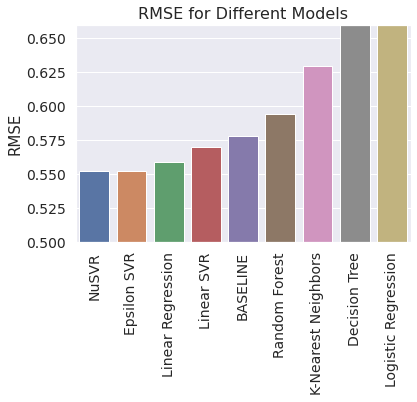

In [28]:
model_results_df = pd.DataFrame(model_results.items(), columns=["Model","RMSE"]).sort_values("RMSE")

ax = sns.barplot(x="Model", y="RMSE", data=model_results_df)
plt.setp(ax.get_xticklabels(), rotation=90);
plt.ylim(.5,.66);
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('');
ax.set_ylabel('RMSE', fontsize=15);
ax.set_title("RMSE for Different Models", fontsize=16);

Acknowledgement:
https://medium.com/@cselig/assessing-the-funniness-of-edited-news-headlines-3ec03056f29a